# ANLP 2020 - Assignment 1


*Sophia Student, 1234567* (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Wednesday, December 2</div>

<div class="alert alert-block alert-info">

**NOTE**

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-1.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle upload. In case of questions, you can reach us via the piazza forum, or by email.<br><br>
<b>For this assignment, do NOT use any external packages (NLTK or any others) EXCEPT where specified.</b>
</div>

<div class="alert alert-block alert-info">
In this assignment, you will implement and work with a Naive Bayes classifier. (Note that for this exercise, you don't need to represent the input as a vector necessarily. You can directly look at the presence of words, and look up the class conditional likelihood.)
<br>
<br>
We will use a Twitter dataset classified into "hate speech" and "non hate speech" (in our data, we have called these classes "offensive" and "nonoffensive" to avoid the charged and inaccurate term "hate speech"). First, load the data (we have provided the function for this):
</div>

In [1]:
import csv
import json
from nltk.tokenize import TweetTokenizer

def read_hate_tweets (annofile, jsonfile):
    """Reads in hate speech data."""
    all_data = {}
    annos = {}
    with open(annofile) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            if row[0] in annos:
                # if duplicate with different rating, remove!
                if row[1] != annos[row[0]]:
                    del(annos[row[0]])
            else:
                annos[row[0]] = row[1]

    tknzr = TweetTokenizer()
                
    with open(jsonfile) as jsonfile:
        for line in jsonfile:
            twtjson = json.loads(line)
            twt_id = twtjson['id_str']
            if twt_id in annos:
                all_data[twt_id] = {}
                all_data[twt_id]['offensive'] = "nonoffensive" if annos[twt_id] == 'none' else "offensive"
                all_data[twt_id]['text_tok'] = tknzr.tokenize(twtjson['text'])

    # split training and test data:
    all_data_sorted = sorted(all_data.items())
    items = [(i[1]['text_tok'],i[1]['offensive']) for i in all_data_sorted]
    splititem = len(all_data)-3250
    train_dt = items[:splititem]
    test_dt = items[splititem:]
    print('Training data:',len(train_dt))
    print('Test data:',len(test_dt))

    return(train_dt,test_dt)

TWEETS_ANNO = 'NAACL_SRW_2016.csv'
TWEETS_TEXT = 'NAACL_SRW_2016_tweets.json'

(train_data,test_data) = read_hate_tweets(TWEETS_ANNO,TWEETS_TEXT)


Training data: 12896
Test data: 3250


<div class="alert alert-block alert-info">
Each item in our data consists of a tuple of the tweet text and its label (represented as a string). The tweet text has been tokenized and is represented as a list of words. We can look at an example item:
</div>

In [2]:
print(train_data[4387])

(['At', 'this', 'rate', ',', "I'm", 'going', 'to', 'be', 'making', 'slides', 'for', 'a', 'keynote', 'in', 'my', 'car', 'as', 'I', 'drive', 'home', '.'], 'nonoffensive')


## Problem 1: Evaluation [15 pts]

<div class="alert alert-block alert-info">

The first thing you're being asked to do is to provide evaluation functions for a classifier and a given labelled test set. Assume that the classifier has a `predict()` function that takes an item in the form of a list as above and predicts a class for that item. Write evaluation functions to compute the `accuracy` and `f_1` score for such a classifier. (To test your functions without having access to a real `predict()` function, you could simulate one that makes random predictions.)

</div>

In [3]:
def accuracy(classifier, data):
    """Computes the accuracy of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The accuracy of the classifier on the test data, a float.
    """
    score = 0
    for x, label in data:
        score+= (classifier.predict(x) == label)
    return score/len(data)

def f_1(classifier, data):
    """Computes the F_1-score of a classifier on reference data.

    Args:
        classifier: A classifier.
        data: Reference data.

    Returns:
        The F_1-score of the classifier on the test data, a float.
    """
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for x, label in data:
        ypred = classifier.predict(x)
        if label == "offensive":
            tp+=(label == ypred)
            fn+=(label != ypred)
        else:
            tn+=(label == ypred)
            fp+=(label != ypred)
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)

    return (2*prec*rec)/(prec+rec)


## Problem 2: Naive Bayes Classifier [35 pts]

<div class="alert alert-block alert-info">
Next, implement the Naive Bayes classifier from scratch using the code skeleton below and the definitions from class.<br><br>

Some requirements and notes for implementation:

<ul>
<li> You should allow for an arbitrary number of classes (in particular, you should not hard code the two classes needed for the given dataset). 
<li> The vocabulary of your classifier should be created dynamically from the training data. (The vocabulary is the set of all words that occur in the training data.).
<li> Use additive smoothing with a provided parameter k. 
<li> You may encounter unknown words at test time. Since we're not allowed to "peek" into the test set, we will implement the following simple treatment: We will assume that we don't know anything about unknown words and that in particular, their presence does not tell us anything about which class a document should be assigned to. Therefore, we will not include them in the calculation of the (log) probabilities during prediction, under the assumption that their probability does not differ hugely between the different classes (probably not a correct assumption, but the best we can do at this point). Since we don't need correct probabilities but only most likely classes, just ignore unknown words during prediction.
<li> Use log probabilities in order to avoid underflow.
</ul>

</div>

In [4]:
class NaiveBayes(object):
    
    def __init__(self, num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab):
        """Initialises a new classifier."""
        self.num_classes = num_classes
        self.classes = classes
        self.dicts = dicts
        self.totals = totals
        self.vocabsize = vocabsize
        self.k = k
        self.num_examples = num_examples
        self.vocab = vocab
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        log_prob = [[math.log2(num/sum(self.num_examples))] for num in self.num_examples]
        for w in x:
            for cnt, d in enumerate(self.dicts):
                if w in self.vocab:
                    val = d.get(w,0)
                    log_prob[cnt].append(math.log2((val + self.k)/(self.totals[cnt] + self.vocabsize)))
        probs = [sum(p) for p in log_prob]
        # print("probs are ", probs)
        idx = probs.index(sorted(probs)[-1])

        return self.classes[idx]
        
    @classmethod
    def train(cls, data, k = 1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        num_classes = len(set(list(zip(*data))[1]))
        classes = list(set(list(zip(*data))[1]))
        dicts = [{} for _ in range(num_classes)]
        num_examples = [0 for _ in range(num_classes)]
        for word, label in data:
            ii = classes.index(label)
            num_examples[ii]+=1
            for w in word:
                if w in dicts[ii].keys():
                    dicts[ii][w]+=1
                else:
                    dicts[ii][w] = 1
        totals = []
        overall = []
        for cnt, dct in enumerate(dicts):
            overall+=dct.keys()
            totals.append(sum(dct.values()))
        vocab = set(overall)
        vocabsize = len(set(overall))
        return cls(num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab)

<div class="alert alert-block alert-info">
Evaluate your classifier by training and testing it on the given data. Vary the smoothing parameter k. What happens when you decrease k? Plot a graph of the accuracy and/or f-score given different values of k. Discuss your findings.</div>

Accuracy:  0.8572307692307692
F_1:  0.5156576200417536


Text(0.5, 1.0, 'Accuracy vs Smooting Paramter')

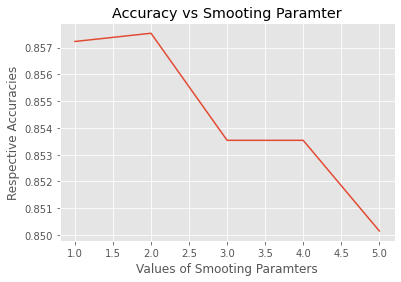

In [8]:
import math
import matplotlib.pyplot as plt

nb = NaiveBayes.train(train_data)
print("Accuracy: ",accuracy(nb, test_data))
print("F_1: ", f_1(nb,test_data))

# TODO: test further smoothing parameters
smooting_param = [1, 2, 3, 4, 5]
ac = []
for k in smooting_param:
    nb = NaiveBayes.train(train_data, k = k)
    ac.append(accuracy(nb, test_data))
plt.style.use("ggplot")
plt.plot(smooting_param, ac)
plt.xlabel("Values of Smooting Paramters")
plt.ylabel("Respective Accuracies")
plt.title("Accuracy vs Smooting Paramter")


When we increase the value of k (smooting Parameter), at k = 2, the model generalizes very well producing a high accuracy on test data however as we further increase the value of k, we are regularizing too much resulting in lower accuracy overall. At lower values of k, model will totally overfit the training data which produces less accuracy as compared to when k = 2.

In [12]:
len(nb.vocab)

25892

## Problem 3: Feature Engineering [20 pts]

<div class="alert alert-block alert-info">

We mentioned that the Naive Bayes classifier can be used with many different feature types. Try to improve on the basic bag of words model by changing the feature list of your model. Implement at least two variants. For each, explain your motivation for this feature set, and test the classifier with the given data. Briefly discuss your results!<br><br> 
Ideas for feature sets that were mentioned in class include:

<ul>
<li> removing stop words or frequent words
<li> stemming or lemmatizing (you can use NLTK or spacy.io for basic NLP operations on the texts)
<li> introducing part of speech tags as features (how?)
<li> bigrams
</ul>

</div>

In [15]:
from nltk.stem import PorterStemmer
class NaiveBayes_Stemming(object):
    
    def __init__(self, num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab, ps):
        """Initialises a new classifier."""
        self.num_classes = num_classes
        self.classes = classes
        self.dicts = dicts
        self.totals = totals
        self.vocabsize = vocabsize
        self.k = k
        self.num_examples = num_examples
        self.vocab = vocab
        self.ps = ps
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        log_prob = [[math.log2(num/sum(self.num_examples))] for num in self.num_examples]
        for w in x:
            w = self.ps.stem(w)
            for cnt, d in enumerate(self.dicts):
                if w in self.vocab:
                    val = d.get(w,0)
                    log_prob[cnt].append(math.log2((val + self.k)/(self.totals[cnt] + self.vocabsize)))
        probs = [sum(p) for p in log_prob]
        # print("probs are ", probs)
        idx = probs.index(sorted(probs)[-1])

        return self.classes[idx]
        
    @classmethod
    def train(cls, data, k = 1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        ps = PorterStemmer()
        num_classes = len(set(list(zip(*data))[1]))
        classes = list(set(list(zip(*data))[1]))
        dicts = [{} for _ in range(num_classes)]
        num_examples = [0 for _ in range(num_classes)]
        for word, label in data:
            ii = classes.index(label)
            num_examples[ii]+=1
            for w in word:
                w = ps.stem(w)
                if w in dicts[ii].keys():
                    dicts[ii][w]+=1
                else:
                    dicts[ii][w] = 1
        totals = []
        overall = []
        for cnt, dct in enumerate(dicts):
            overall+=dct.keys()
            totals.append(sum(dct.values()))
        vocab = set(overall)
        vocabsize = len(set(overall))
        return cls(num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab, ps)


In [16]:
nb = NaiveBayes_Stemming.train(train_data)
print("Accuracy: ",accuracy(nb, test_data))
print("F_1: ", f_1(nb,test_data))

Accuracy:  0.8581538461538462
F_1:  0.5182863113897597


In [22]:
len(stopwords.words('english'))

179

In [19]:
from nltk.corpus import stopwords
class NaiveBayes_stopwords(object):
    
    def __init__(self, num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab):
        """Initialises a new classifier."""
        self.num_classes = num_classes
        self.classes = classes
        self.dicts = dicts
        self.totals = totals
        self.vocabsize = vocabsize
        self.k = k
        self.num_examples = num_examples
        self.vocab = vocab
        pass

    def predict(self, x):
        """Predicts the class for a document.

        Args:
            x: A document, represented as a list of words.

        Returns:
            The predicted class, represented as a string.
        """
        log_prob = [[math.log2(num/sum(self.num_examples))] for num in self.num_examples]
        for w in x:
            for cnt, d in enumerate(self.dicts):
                if w in self.vocab:
                    val = d.get(w,0)
                    log_prob[cnt].append(math.log2((val + self.k)/(self.totals[cnt] + self.vocabsize)))
        probs = [sum(p) for p in log_prob]
        # print("probs are ", probs)
        idx = probs.index(sorted(probs)[-1])

        return self.classes[idx]
        
    @classmethod
    def train(cls, data, k = 1):
        """Train a new classifier on training data using maximum
        likelihood estimation and additive smoothing.

        Args:
            cls: The Python class representing the classifier.
            data: Training data.
            k: The smoothing constant.

        Returns:
            A trained classifier, an instance of `cls`.
        """
        stop_words = stopwords.words('english')
        signs = ['.', ',', ':', "!", "?", "@", "$", "#"]
        stop_words = stop_words + signs
        num_classes = len(set(list(zip(*data))[1]))
        classes = list(set(list(zip(*data))[1]))
        dicts = [{} for _ in range(num_classes)]
        num_examples = [0 for _ in range(num_classes)]
        for word, label in data:
            ii = classes.index(label)
            num_examples[ii]+=1
            for w in word:
                if w not in stop_words:
                    if w in dicts[ii].keys():
                        dicts[ii][w]+=1
                    else:
                        dicts[ii][w] = 1
        totals = []
        overall = []
        for cnt, dct in enumerate(dicts):
            overall+=dct.keys()
            totals.append(sum(dct.values()))
        vocab = set(overall)
        vocabsize = len(set(overall))
        return cls(num_classes, classes, dicts, totals, vocabsize, k, num_examples, vocab)

In [20]:
nb = NaiveBayes_stopwords.train(train_data)
print("Accuracy: ",accuracy(nb, test_data))
print("F_1: ", f_1(nb,test_data))

Accuracy:  0.86
F_1:  0.5352400408580184


In [21]:
nb.vocabsize

25722

## Problem 4: Logistic Regression Classifier [30 pts]

<div class="alert alert-block alert-info">
    
Implement a logistic regression classifier using the definitions given in class and gradient descent. For this, you will have to use a matrix representation for your data to keep track of each feature's weights per class, which you can implement using the `numpy` package. <br><br> 
Start by implementing a function `featurize()` that converts the (training or testing) data into a matrix format. This function should return a pair of NumPy matrices 𝑿, 𝒀, where 𝑿 is an 𝑁 × 𝐹 matrix (𝑁: number of data instances, 𝐹: number of features), and where 𝒀 is an 𝑁 × 2 matrix whose rows have one of two forms:<br><br>
[1, 0] if the gold-standard annotation class for the corresponding tweet is ‘offensive’, or <br><br>
[0, 1] if the gold-standard class for the corresponding document is ‘nonoffensive’<br><br>
This kind of representation is known as a one-hot encoding. You can read the first vector as saying that ‘there is a 100% chance that the instance belongs to the “offensive” class and a 0% chance that it belongs to the “nonoffensive” class’, and similarly for the second vector. Note that these are the two extreme cases for the conditional probability distribution P(k|x) for class k and feature vector x.<br><br>
To implement the `featurize()` function, you will need to assign to each word in the training set a unique integer index which will identify that component of the feature vector which is 1 if the corresponding word is present in the document, and 0 otherwise. This index is built by the helper function `build_w2i()`.<br><br>
Your next task is to complete the implementation of the `LogReg` class. The methods `p()` and `predict()` yield the probability of a class given an item, and the best class for the item, respectively. They can be implemented using appropriate NumPy matrix operations and the provided `softmax()` function. Note that you should set up both methods to take a whole matrix of input vectors as input, not just a single vector.<br><br>
The training procedure is implemented in the (class) method `train()`, using iterative optimization. Typically, we shuffle the training data and split them into mini-batches (e.g, 100 items), then update the weights after each minibatch. This is done for `max_iter` number of iterations, or "epochs". Each epoch iterates over the training data set once.<br><br>
Implement the missing methods using l_2 regularization with parameter C=0.1

</div>

In [27]:
import numpy as np

class LogReg:
    def __init__(self, eta=0.01, num_iter=30, C = 0.1):
        self.eta = eta
        self.num_iter = num_iter
        self.C = C
    

    def softmax(self, inputs):
        """
        Calculate the softmax for the give inputs (array)
        :param inputs:
        :return:
        """
        return np.exp(inputs)/(np.sum(np.exp(inputs), axis=1).reshape(-1,1))
    
    def train(self, X, Y):

        # weights initialization
        self.weights = np.zeros((X.shape[1], Y.shape[1]))
        
        for i in range(self.num_iter):
            ii = np.random.permutation(X.shape[0])
            X = X[ii,:]
            Y = Y[ii,:]
            for j in range(int(X.shape[0]/100) + 1):
                xmini = X[j*100: j*100 + 100]
                ymini = Y[j*100: j*100 + 100]
                prod = np.matmul(xmini, self.weights)
                o = self.softmax(prod)
                loss = -1* np.sum(np.sum(np.multiply(np.log(o), ymini), axis= 1)) + np.sum(self.weights)
                grad = (1/(xmini.shape[0])) * np.matmul(xmini.T, (o - ymini)) + 2 * (1/self.C) * self.weights
                self.weights-= self.eta*grad
            if i%5 == 0:
                print(f"For the interation {i}, The loss is {loss}")
        return None
    
    
    def featurize(self, data, training = True):
        lst, label = list(zip(*data))
        self.classes = list(set(label))
        if training:
            self.vocab = []
            for doc in lst:
                self.vocab+=doc
            self.vocab = np.asarray(list(set(self.vocab)))
        xtr = np.zeros((len(lst), len(self.vocab)))
        ytr = np.zeros((len(lst), len(self.classes)))
        for c, (doc, lbl) in enumerate(zip(lst, label)):
            xtr[c, self.build_w2i(self.vocab, np.asarray(doc))] = 1
            ytr[c, self.classes.index(lbl)] = 1
        return xtr, ytr
    
    def build_w2i(self, vocab, doc):
        return np.isin(vocab, doc)
    
    
    def p(self, X): 
        X, _ = self.featurize(X, training= False)
        return self.softmax(np.matmul(X, self.weights))
        
    
    def predict(self, X):
        prob = self.p(X)
        ii = np.argmax(prob, axis = 1).reshape(-1,1)
        return np.asarray(self.classes)[ii]

<div class="alert alert-block alert-info">
Test your implementation using 10 iterations, default learning rate eta, and l_2 regularization with parameter C=0.1.
</div>

In [28]:
logclass = LogReg(eta = 0.1, num_iter= 10, C= 0.1)
xtr, ytr = logclass.featurize(train_data)
logclass.train(xtr, ytr)

For the interation 0, The loss is 642.4735380588777


MemoryError: Unable to allocate 2.49 GiB for an array with shape (12896, 25892) and data type float64

In [94]:
del(train_data)

In [95]:
_,yte = logclass.featurize(test_data, training= False)

In [92]:
ypred = logclass.predict(test_data)

In [106]:
prob = logclass.p(test_data)

In [107]:
prob[:5,:]

array([[-0.13524571, -2.06752289],
       [-0.29482681, -1.36516141],
       [-0.0640862 , -2.77939818],
       [-0.14546562, -1.99966677],
       [-0.08597697, -2.49635627]])

In [24]:
import numpy as np
a = np.array([[1,2],[3,4]])
np.sum(a)

10